In [5]:
#!conda install -y -c conda-forge pyarrow

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
import re
import csv

%matplotlib inline
%config Completer.use_jedi = False

**Set parameters**

In [2]:
plt.rcParams["axes.labelweight"] = "bold"

sns.set_palette("deep")
sns.set_style("white")
sns.set_context("paper", font_scale = 2.0, rc={"grid.linewidth": 2.5, 'fontweight':'bold'})
plt.rcParams['patch.linewidth'] = 0 # 0.8
plt.rcParams['patch.edgecolor'] = 'none' # 'w'
plt.rcParams["patch.force_edgecolor"] = False # True
plt.rc('legend', fontsize=20, title_fontsize=20)

**Load jobs and GPU failures**

In [3]:
%%time
JOBS = '/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_jobs/jobs.csv'
PERNODE_JOBS = '/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_perhost_jobs/pernode_jobs.csv'
START = 'begin_time'
END = 'end_time'
NODE_HOURS = 'node_hours'
FREQ = 'freq'
PROJ = 'account'
JOB_ID = 'allocation_id'
SIZE = 'size'

jobs_raw = pd.read_csv(JOBS, parse_dates=[START, END], usecols=[JOB_ID, PROJ, START, END], index_col=JOB_ID)
pernode_jobs = pd.read_csv(PERNODE_JOBS, usecols=[JOB_ID])

CPU times: user 1min 1s, sys: 6.18 s, total: 1min 7s
Wall time: 1min 12s


In [4]:
%%time
job_sizes = pernode_jobs.groupby(JOB_ID).size().rename(SIZE)
jobs = jobs_raw.merge(job_sizes, left_index=True, right_index=True)
jobs[NODE_HOURS] = (jobs[END] - jobs[START]).dt.total_seconds() / 3600 * jobs[SIZE]

jobs = jobs.dropna()
jobs = jobs[jobs[END] >= jobs[START]]
proj_node_hours = jobs.groupby(PROJ, as_index=False)[NODE_HOURS].sum()

CPU times: user 2.42 s, sys: 570 ms, total: 2.99 s
Wall time: 3 s


In [5]:
FAILURES = '/gpfs/alpine/stf218/proj-shared/data/lake.dev/summit_gpu_failures_project_merge/gpu_failures_project.csv'
NODE = 'hostname'
XID = 'xid'

failures_raw = pd.read_csv(FAILURES, usecols=[NODE, PROJ, XID])

In [6]:
xid_names = {
    31: 'Memory page fault', 13: 'Graphics engine exception', 43: 'Stopped processing', 74: 'NVLINK error',
    63: 'Page retirement event', 64: 'Page retirement failure', 48: 'Double-bit error', 45: 'Preemptive cleanup',
    61: 'Internal microcontroller warning', 44: 'Graphics engine fault', 79: 'Fallen off the bus', 62: 'Internal microcontroller halt',
    38: 'Driver firmware error', 32: 'Corrupted push buffer stream', 12: 'Driver error handling exception', 69: 'Graphics engine class error'}


**Clean the data**

In [7]:
# Remove data for login and batch nodes.
failures_raw = failures_raw[~failures_raw[NODE].str.startswith('login') & ~failures_raw[NODE].str.startswith('batch')]

In [8]:
failures_raw = failures_raw[[PROJ, XID]].dropna()

In [36]:
N = 'n'
TOT_FREQ = 'total_freq'

proj_xid = failures_raw.groupby([PROJ, XID], as_index=False).size().rename(columns={'size': N})

**Find failure frequency for each project-XID pair**

In [37]:
proj_xid = proj_xid.merge(proj_node_hours, on=PROJ)
proj_xid_hardware = proj_xid[proj_xid[XID].isin({48, 62, 63, 64, 74, 79})].copy()#.merge(proj_node_hours, on=PROJ)
for df in [proj_xid, proj_xid_hardware]:
    df[FREQ] = df[N] / df[NODE_HOURS]
    df[TOT_FREQ] = df.groupby(PROJ, as_index=False)[FREQ].transform('sum')
    df.sort_values(TOT_FREQ, ascending=False, inplace=True)
    df.drop(df.index[~df[PROJ].isin(df[PROJ].unique()[:15])], inplace=True)

**Sanitize project names**

In [38]:
with open('/gpfs/alpine/stf218/proj-shared/25amk/domain_proj.csv', mode='r') as inp:
    reader = csv.reader(inp)
    domain_descs = {domain: desc for domain, desc in reader}

In [46]:
from string import ascii_uppercase

projects = sorted(pd.concat([proj_xid, proj_xid_hardware])[PROJ].unique())
clean_projects = dict()
domain = ''
for proj in projects:
    if proj[:3] == domain:
        i += 1
    else:
        domain = proj[:3]
        i = 0
    clean_projects[proj] = f'{domain_descs.get(domain, domain)} {ascii_uppercase[i]}'

In [47]:
PROJ_CLEAN = 'account_clean'
proj_xid[PROJ_CLEAN] = proj_xid[PROJ].map(clean_projects)
proj_xid_hardware[PROJ_CLEAN] = proj_xid_hardware[PROJ].map(clean_projects)

**Plot failure frequency per project**

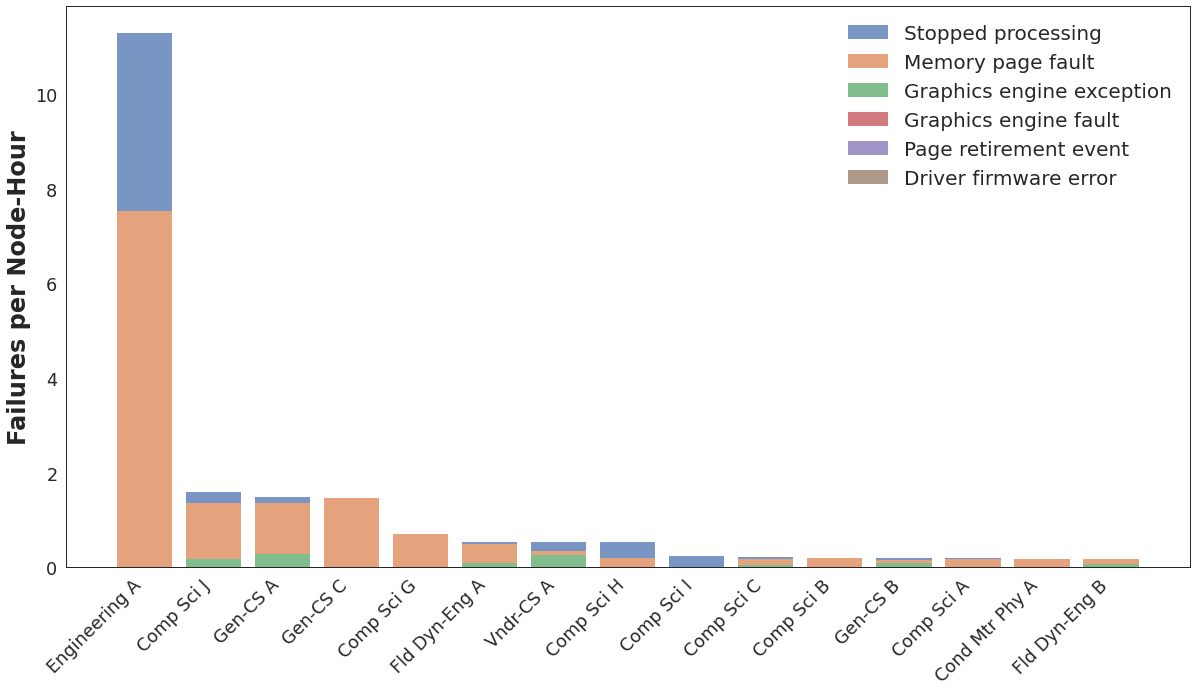

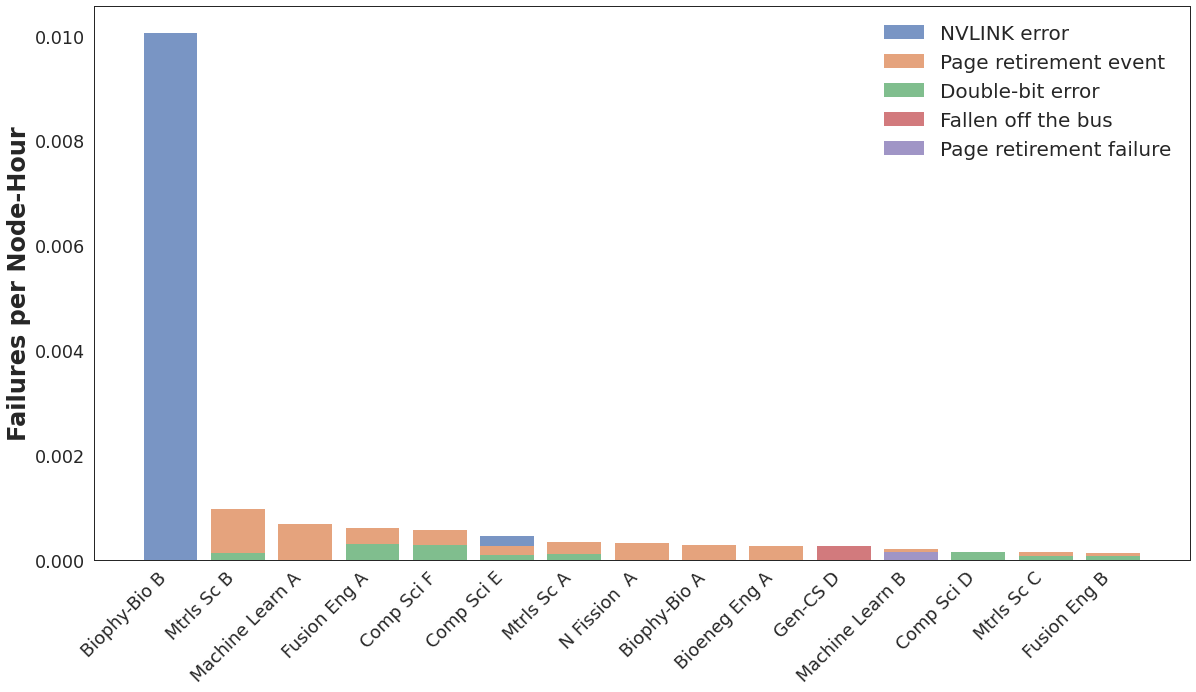

In [48]:
FAILURE = 'failure'
for is_hardware, df in enumerate([proj_xid, proj_xid_hardware]):
    data = df[df[PROJ_CLEAN].isin(df[PROJ_CLEAN].unique()[:15])].rename(columns={XID: FAILURE})
    data[FAILURE] = data[FAILURE].apply(xid_names.get)

    fig = plt.figure(figsize=(17, 10))
    plt.xticks(rotation=45, ha='right')
    ax = sns.histplot(data, x=PROJ_CLEAN, hue=FAILURE, weights=FREQ, multiple='stack', shrink=0.8)
    ax.legend_.set_title('')
    plt.xlabel('')
    plt.ylabel('Failures per Node-Hour', fontsize=24)
    output_name = ('hardware_' if is_hardware else '') + 'failures_per_project'
    fig.tight_layout()
    fig.savefig(f'../plots/{output_name}.pdf')